In [1]:
# Hybrid Stock Price Predictor: LSTM + Fundamental Analysis (Optimized Final Version)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate


In [2]:
# 1. Load Stock Data
start = '2012-01-01'
end = '2025-06-14'
stock = 'GOOG'
data = yf.download(stock, start, end)[['Close']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_20724\4150500671.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start, end)[['Close']]
[*********************100%***********************]  1 of 1 completed


In [3]:
# 2. Data Cleaning
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

# Remove outliers using IQR
q1 = data['Close'].quantile(0.25)
q3 = data['Close'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]
data.reset_index(drop=True, inplace=True)

In [4]:
# 3. Add Technical Indicators (Corrected and Accurate)

# Rolling statistics
data['Rolling_Mean'] = data['Close'].rolling(window=30).mean()
data['Rolling_STD'] = data['Close'].rolling(window=30).std()
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Exponential Moving Averages
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()

# MACD, Signal Line, and Histogram
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']

# Improved RSI using Wilder's Smoothing
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

# Initialize Series
avg_gain = pd.Series(index=data.index, dtype='float64')
avg_loss = pd.Series(index=data.index, dtype='float64')

# First values (simple mean)
avg_gain.iloc[14] = gain.iloc[1:15].mean()
avg_loss.iloc[14] = loss.iloc[1:15].mean()

# Wilder's smoothing
for i in range(15, len(data)):
    avg_gain.iloc[i] = (avg_gain.iloc[i-1] * 13 + gain.iloc[i]) / 14
    avg_loss.iloc[i] = (avg_loss.iloc[i-1] * 13 + loss.iloc[i]) / 14

# RSI Calculation
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
data['RSI'] = rsi

# Drop initial NA values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

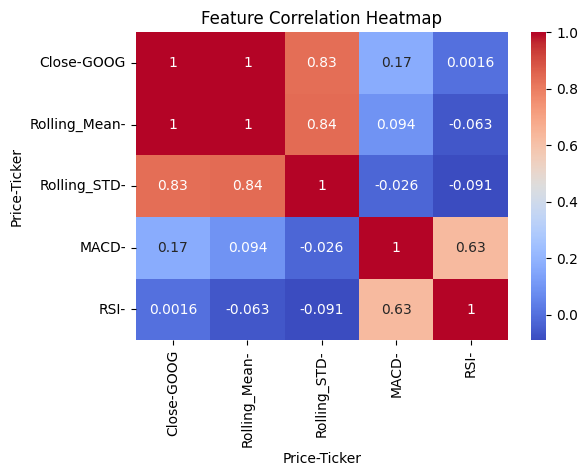

In [5]:
# 4. Visualize Correlation
plt.figure(figsize=(6, 4))
sns.heatmap(data[['Close', 'Rolling_Mean', 'Rolling_STD', 'MACD', 'RSI']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [6]:
# 5. Train-Test Split
train_size = int(len(data) * 0.8)
data_train = data[:train_size][['Close']]
data_test = data[train_size:][['Close']]

In [7]:
# 6. Scaling
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(data_train)

In [8]:
# 7. Prepare Training Data
x_train, y_train = [], []
for i in range(100, data_train_scaled.shape[0]):
    x_train.append(data_train_scaled[i-100:i])
    y_train.append(data_train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# 8. Train LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=64, verbose=1)


Epoch 1/50


C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - loss: 0.0677
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - loss: 0.0084
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - loss: 0.0055
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - loss: 0.0051
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0043
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - loss: 0.0050
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0039
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0048
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0040
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - loss: 0.0037
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - loss: 0.0032
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.0030
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - loss: 0.0038
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - loss: 0.0031
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - loss: 0.

In [ ]:
# 9. Prepare Test Data
last_100 = data_train.tail(100)
data_test_full = pd.concat([last_100, data_test], ignore_index=True)
data_test_scaled = scaler.transform(data_test_full)

x_test, y_test = [], []
for i in range(100, data_test_scaled.shape[0]):
    x_test.append(data_test_scaled[i-100:i])
    y_test.append(data_test_scaled[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)


In [ ]:
# 10. Predict
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [ ]:
# 11. Evaluate
mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
tech_accuracy = 100 - mape

print(f"MSE: {mse:.4f}\nMAE: {mae:.4f}\nR2 Score: {r2:.4f}\nMAPE: {mape:.2f}%")
print(f"Technical Prediction Accuracy: {tech_accuracy:.2f}%")


In [ ]:
# 12. Plot Actual vs Predicted with RSI, MACD, and Moving Averages

# Compute 100 and 200 day moving averages
data['MA_100'] = data['Close'].rolling(window=100).mean()
data['MA_200'] = data['Close'].rolling(window=200).mean()

# Plot combined indicators
plt.figure(figsize=(14, 6))
plt.plot(y_actual, label='Actual Price', linewidth=2)
plt.plot(y_pred, label='Predicted Price', linewidth=2)
plt.plot(data.iloc[-len(y_pred):]['RSI'].values, label='RSI', linestyle='--', alpha=0.5)
plt.plot(data.iloc[-len(y_pred):]['MACD'].values, label='MACD', linestyle='--', alpha=0.5)
plt.plot(data.iloc[-len(y_pred):]['MA_100'].values, label='100-Day MA', linestyle='-.', color='orange')
plt.plot(data.iloc[-len(y_pred):]['MA_200'].values, label='200-Day MA', linestyle='-.', color='purple')

plt.title(f'{stock} Price Prediction with Indicators & MAs')
plt.xlabel('Time')
plt.ylabel('Price / Indicator')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 13. Fundamental Analysis
API_KEY = 'BISBYX9HTP79QMXV'
def fetch_data(url):
    try:
        return requests.get(url).json()
    except:
        return None

def get_fundamentals(symbol):
    overview = fetch_data(f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={symbol}&apikey={API_KEY}')
    if not overview:
        return [0, 0, 0, 0], ["Unavailable"] * 4
    try:
        pe = float(overview.get('PERatio', 0))
        pb = float(overview.get('PriceToBookRatio', 0))
        roe = float(overview.get('ReturnOnEquityTTM', 0))
        mc = float(overview.get('MarketCapitalization', 0)) / 1e9
        evals = [
            "Good" if pe <= 30 else "Bad",
            "Good" if pb <= 10 else "Bad",
            "Good" if roe >= 0.15 else "Bad",
            "Good" if mc >= 10 else "Bad"
        ]
        return [pe, pb, roe, mc], evals
    except:
        return [0, 0, 0, 0], ["Unavailable"] * 4

fundamentals, fund_eval = get_fundamentals(stock)
labels = ['PE Ratio', 'PB Ratio', 'ROE', 'Market Cap (B)']
table = [[labels[i], fundamentals[i], fund_eval[i]] for i in range(4)]
print("\nFundamental Analysis Table:")
print(tabulate(table, headers=['Metric', 'Value', 'Evaluation'], tablefmt="grid"))


In [ ]:
# 14. Recommendation
fund_strong = fund_eval.count("Good") >= 3
tech_strong = r2 > 0.70 and tech_accuracy >= 80
print("\nFinal Recommendation:")
if fund_strong:
    print("✅ Fundamentally strong")
else:
    print("⚠️ Fundamental concerns")
if tech_strong:
    print("✅ Technically strong")
else:
    print("⚠️ Technical performance weak")
if fund_strong and tech_strong:
    print("📈 Consider for investment")
elif fund_strong:
    print("📉 Good fundamentals, weak tech")
elif tech_strong:
    print("📉 Good techs, weak fundamentals")
else:
    print("❌ Avoid or review further")

In [ ]:
# 15. Combined Accuracy
fund_accuracy = sum([1 if e == "Good" else 0 for e in fund_eval]) / 4 * 100
combined_accuracy = (tech_accuracy + fund_accuracy) / 2
print(f"\nCombined Prediction Accuracy: {combined_accuracy:.2f}%")


In [ ]:
model.save("lstm_stock_predictor.h5", include_optimizer=False, save_format='h5')
